# A minimal MCNN example

Given an image of [Lenna](https://en.wikipedia.org/wiki/Lenna), we can simulate its second gradient with a [Laplace operator](https://en.wikipedia.org/wiki/Laplace_operator).

One of the ways for the simulation is an image convolution with a discrete kernel

\begin{vmatrix}
1&2&1\\
2&-12&2\\
1&2&1\\
\end{vmatrix}

This is straightforward and easy

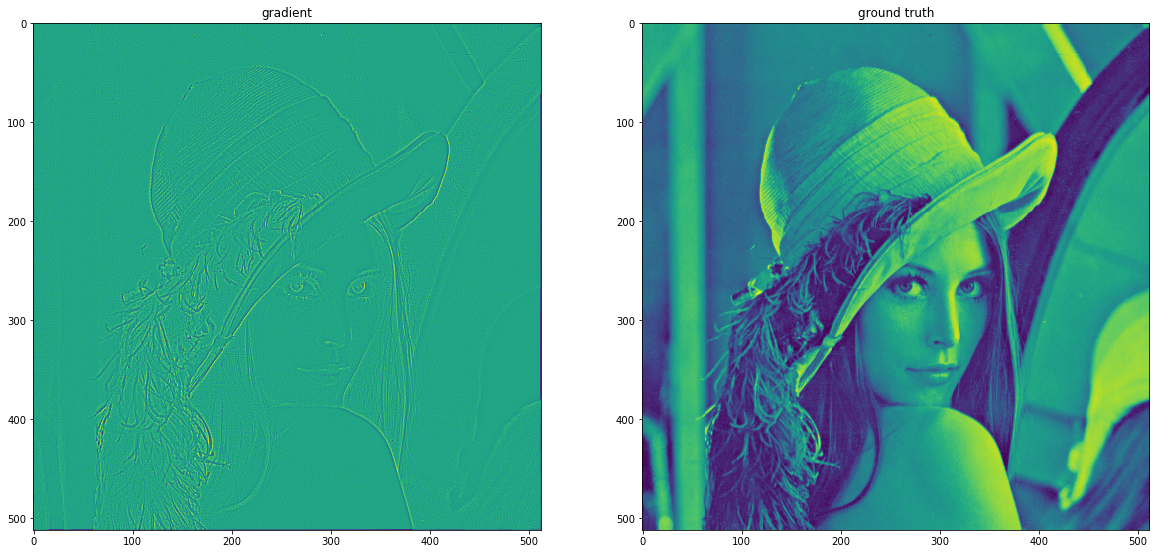

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

import tifffile
ground_truth = tifffile.imread( './images/lena.tif')

import numpy as np
kernel = np.asarray( [[1, 2, 1], [2, -12, 2], [1, 2, 1]], dtype='float32' )
ground_truth = (ground_truth-np.amin(ground_truth))/(np.amax(ground_truth)-np.amin(ground_truth))

from scipy.signal import convolve
gradient = convolve( ground_truth, kernel, mode='same' )

fig, axs = plt.subplots(1, 2)
axs[0].set_title('gradient')
axs[0].imshow(gradient)
axs[1].set_title('ground truth')
axs[1].imshow(ground_truth)
plt.show()

The phase problem involves reconstruction the original image from its gradient.
To solve this problem with deep convolutional neural networks, first we need to check if the framework [tensorflow](https://www.tensorflow.org) has been installed or not. This can be done by

In [2]:
import tensorflow
print( tensorflow.__version__)

1.14.0


Then we start to implement our MCNN model.
First we define our [kernel initializer](https://arxiv.org/abs/1502.01852) and regularizer

In [3]:
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.initializers import he_normal
kr = regularizers.l2( 1.0e-3 )
ki = he_normal()

With `kr` and `ki`, we define the classic U-Net structure

In [4]:
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.merge import add

init = Input(shape=(512, 512, 1))
init_ = Conv2D( 32, kernel_size=(31, 31), activation = "relu", strides = 1, padding="same", kernel_regularizer=kr, kernel_initializer=ki )( init )
l1 = Conv2D( 64, kernel_size=(7, 7), activation = "relu", strides = 2, padding="same", kernel_regularizer=kr, kernel_initializer=ki )( init_ )
l2=Conv2D(128, kernel_size=(5, 5), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l1) # 128
l3=Conv2D(192, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l2) # 64
l4=Conv2D(256, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l3) # 32
l5=Conv2D(384, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l4) # 16
l6=Conv2D(512, kernel_size=(3, 3), activation="relu", strides=2, padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l5) # 8
lx1=Conv2D(768, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(l6) # 6
lx1=Conv2D(1024, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(lx1) # 4
lx2=Conv2D(2048, kernel_size=(3, 3), activation="relu", strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki)(lx1) # 2
lx3=Conv2DTranspose(1024, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx2) # 4
lx4=add([lx3, lx1])
lx5=Conv2DTranspose(768, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx4) # 6
l7=Conv2DTranspose(512, kernel_size=(3, 3), strides=(1,1), padding='valid', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(lx5) # 8
l9=add([l7, l6]) #
l10=Conv2DTranspose(384, kernel_size=(3, 3), strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki, activation="relu")(l9) # 16
l12=add([l10, l5]) #
l13=Conv2DTranspose(256, kernel_size=(3, 3),  activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l12) # 32
l15=add([l13, l4]) #
l16=Conv2DTranspose(192, kernel_size=(3, 3), strides=(2,2), activation="relu", padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l15) # 64
l18=add([l16, l3]) #
l19=Conv2DTranspose(128, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l18) # 128
l21=add([l19, l2]) #
l22=Conv2DTranspose(64, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l21) # 256
l24=add([l22, l1])
l25=Conv2DTranspose(32, kernel_size=(3, 3), activation="relu", strides=(2,2), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l24) # 512
l27=add([l25, init_])
llast=Conv2D(16 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l27)
llast=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(llast)
last512=Conv2D(1, kernel_size=(31, 31), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_512")(llast)
#unet = Model( init, last512 )

MCNN epxands the layers in the decoder to match low-frequency components. The expanded layers can be defined this way to make a model

In [5]:
last4=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(lx4)
last4=Conv2D(1, kernel_size=(3, 3), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_4")(last4)

last8=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l9)
last8=Conv2D(1, kernel_size=(5, 5), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_8")(last8)

last16=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l12)
last16=Conv2D(1, kernel_size=(5, 5), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_16")(last16)

last32=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l15)
last32=Conv2D(1, kernel_size=(7, 7), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_32")(last32)

last64=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l18)
last64=Conv2D(1, kernel_size=(9, 9), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_64")(last64)

last128=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l21)
last128=Conv2D(1, kernel_size=(11, 11), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_128")(last128)

last256=Conv2D(8 , kernel_size=(3, 3), activation='relu', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki)(l24)
last256=Conv2D(1, kernel_size=(17, 17), activation='sigmoid', strides=(1,1), padding='same', kernel_regularizer=kr, kernel_initializer=ki, name="gen_256")(last256)

mcnn = Model(inputs=init, outputs=[last512, last256, last128, last64, last32, last16, last8, last4])
mcnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 30784       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 100416      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 128 204928      conv2d_1[0][0]                   
______________________________________________________________________________________________

With 2 GPUs, we make the training plan using [Adam](https://arxiv.org/abs/1412.6980) minimizing the mean absolute errros

In [6]:
from tensorflow.python.keras.utils import multi_gpu_model
mcnn = multi_gpu_model( mcnn, gpus=2 )
mcnn.compile( loss='mae', optimizer='adam' )

The low frequency components data can be generated by pooling the original images sequencially. This is done by

In [7]:
from skimage.measure import block_reduce
def make_block_reduce( input_layers, dim=(2,2), mode=np.mean ):
    stacked_layers = [ block_reduce( image, dim, mode ) for image in input_layers ]
    return np.asarray( stacked_layers, dtype='float32' )

Then by simulating the gradient images from some existing image set, for example [ImageNet](http://www.image-net.org/), we can prepare a training/validation dataset with 1024 samples this way

In [8]:
import glob
paths = glob.glob( '/raid/feng/pictures/openimagenet.v5/*.jpg')

import random    
random.shuffle( paths )

shape = (512, 512)
number = 1024
gaussian_noise_var = 0.01

from imageio import imread
def trim_image_from_path( image_path, shape ):
    try:
        image = imread( image_path )
    except:
        return None
    image = np.asarray( image, dtype='float32' )
    image = image / 255.0

    if 3 == len(image.shape): # rgb -> gray
        image = 0.2627*image[:,:,0]+0.6780*image[:,:,1]+0.0593*image[:,:,2]

    scaling_ratio = [ int(a/b) for a, b in zip( image.shape, shape ) ]
    if scaling_ratio[0] > 1 and scaling_ratio[1] > 1 :
        image = block_reduce( image, tuple(scaling_ratio), np.mean )

    dim_diff = [ (a - b)>>1 for a, b in zip( image.shape, shape ) ]
    if dim_diff[0] < 0 or dim_diff[1] < 0:
        return None
    return image[dim_diff[0]:dim_diff[0]+shape[0], dim_diff[1]:dim_diff[1]+shape[1]]

output_images = []
input_images = []
counter = 0
for path in paths:
    trimmed_image = trim_image_from_path(path, shape )
    if trimmed_image is not None:
        print( f'preparing training set from {path} - {counter}/{number}', end='\r' )
        output_images.append(trimmed_image)
        input_images.append( convolve( trimmed_image, kernel, mode='same' ) )
        counter += 1
    if counter == number:
        break

input_layers = np.asarray( input_images, dtype='float32' ).reshape( (number,)+shape+(1,) )
input_layers += np.random.normal(loc=0.0, scale=gaussian_noise_var, size=input_layers.shape)
#input_layers = ( input_layers-np.mean(input_layers) ) / (np.std(input_layers) + 1.0e-10)

output_layers = [np.asarray( output_images, dtype='float32' ), None, None, None, None, None, None, None]
for idx in range( 7 ):
    output_layers[idx+1] = make_block_reduce( output_layers[idx], (2,2), np.mean )
    output_layers[idx] = output_layers[idx].reshape( output_layers[idx].shape + (1,) )
output_layers[7] = output_layers[7].reshape( output_layers[7].shape + (1,) )

The gradient and the ground truth for the first image-pair are visualized below

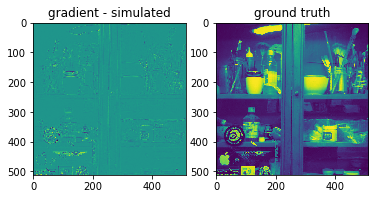

In [9]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('gradient - simulated')
axs[0].imshow(np.squeeze(input_layers[0]))
axs[1].set_title('ground truth')
axs[1].imshow(np.squeeze(output_layers[0][0]))
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

With a simple training history recoder

For demonstration, we train the model 128 epochs with a batch size of 8 and a validation split of 1/4. In actural applications, the epochs and the size of the training set should be much larger.

In [10]:
mcnn.fit( input_layers, output_layers, batch_size=8, epochs=128, verbose=1,validation_split=0.25 )

Train on 768 samples, validate on 256 samples
Epoch 1/128
768/768 [==============================] - 95s 124ms/sample - loss: 6.4423 - gen_512_loss: 0.2208 - gen_256_loss: 0.2215 - gen_128_loss: 0.2175 - gen_64_loss: 0.2131 - gen_32_loss: 0.2061 - gen_16_loss: 0.1945 - gen_8_loss: 0.1800 - gen_4_loss: 0.1582 - val_loss: 2.3088 - val_gen_512_loss: 0.2118 - val_gen_256_loss: 0.2238 - val_gen_128_loss: 0.2193 - val_gen_64_loss: 0.2082 - val_gen_32_loss: 0.2059 - val_gen_16_loss: 0.1942 - val_gen_8_loss: 0.1789 - val_gen_4_loss: 0.1578
Epoch 2/128
768/768 [==============================] - 80s 104ms/sample - loss: 1.8159 - gen_512_loss: 0.1913 - gen_256_loss: 0.1971 - gen_128_loss: 0.1923 - gen_64_loss: 0.1849 - gen_32_loss: 0.1767 - gen_16_loss: 0.1709 - gen_8_loss: 0.1605 - gen_4_loss: 0.1421 - val_loss: 1.5161 - val_gen_512_loss: 0.1717 - val_gen_256_loss: 0.1678 - val_gen_128_loss: 0.1661 - val_gen_64_loss: 0.1652 - val_gen_32_loss: 0.1590 - val_gen_16_loss: 0.1574 - val_gen_8_loss: 0.

Epoch 18/128
768/768 [==============================] - 83s 108ms/sample - loss: 0.7464 - gen_512_loss: 0.0859 - gen_256_loss: 0.0896 - gen_128_loss: 0.0861 - gen_64_loss: 0.0816 - gen_32_loss: 0.0766 - gen_16_loss: 0.0733 - gen_8_loss: 0.0692 - gen_4_loss: 0.0745 - val_loss: 0.7268 - val_gen_512_loss: 0.0833 - val_gen_256_loss: 0.0861 - val_gen_128_loss: 0.0830 - val_gen_64_loss: 0.0781 - val_gen_32_loss: 0.0731 - val_gen_16_loss: 0.0703 - val_gen_8_loss: 0.0649 - val_gen_4_loss: 0.0768
Epoch 19/128
768/768 [==============================] - 82s 107ms/sample - loss: 0.6892 - gen_512_loss: 0.0784 - gen_256_loss: 0.0819 - gen_128_loss: 0.0789 - gen_64_loss: 0.0745 - gen_32_loss: 0.0696 - gen_16_loss: 0.0664 - gen_8_loss: 0.0621 - gen_4_loss: 0.0679 - val_loss: 0.7187 - val_gen_512_loss: 0.0804 - val_gen_256_loss: 0.0847 - val_gen_128_loss: 0.0819 - val_gen_64_loss: 0.0776 - val_gen_32_loss: 0.0729 - val_gen_16_loss: 0.0705 - val_gen_8_loss: 0.0686 - val_gen_4_loss: 0.0730
Epoch 20/128
7

Epoch 35/128
768/768 [==============================] - 83s 108ms/sample - loss: 0.5924 - gen_512_loss: 0.0665 - gen_256_loss: 0.0684 - gen_128_loss: 0.0651 - gen_64_loss: 0.0618 - gen_32_loss: 0.0577 - gen_16_loss: 0.0550 - gen_8_loss: 0.0514 - gen_4_loss: 0.0552 - val_loss: 0.7643 - val_gen_512_loss: 0.0919 - val_gen_256_loss: 0.0929 - val_gen_128_loss: 0.0881 - val_gen_64_loss: 0.0841 - val_gen_32_loss: 0.0817 - val_gen_16_loss: 0.0770 - val_gen_8_loss: 0.0681 - val_gen_4_loss: 0.0702
Epoch 36/128
768/768 [==============================] - 82s 107ms/sample - loss: 0.5733 - gen_512_loss: 0.0641 - gen_256_loss: 0.0664 - gen_128_loss: 0.0629 - gen_64_loss: 0.0595 - gen_32_loss: 0.0555 - gen_16_loss: 0.0530 - gen_8_loss: 0.0490 - gen_4_loss: 0.0531 - val_loss: 0.6469 - val_gen_512_loss: 0.0735 - val_gen_256_loss: 0.0744 - val_gen_128_loss: 0.0713 - val_gen_64_loss: 0.0693 - val_gen_32_loss: 0.0647 - val_gen_16_loss: 0.0606 - val_gen_8_loss: 0.0588 - val_gen_4_loss: 0.0640
Epoch 37/128
7

Epoch 52/128
768/768 [==============================] - 83s 107ms/sample - loss: 0.5461 - gen_512_loss: 0.0609 - gen_256_loss: 0.0620 - gen_128_loss: 0.0584 - gen_64_loss: 0.0549 - gen_32_loss: 0.0522 - gen_16_loss: 0.0497 - gen_8_loss: 0.0459 - gen_4_loss: 0.0484 - val_loss: 0.6423 - val_gen_512_loss: 0.0713 - val_gen_256_loss: 0.0751 - val_gen_128_loss: 0.0707 - val_gen_64_loss: 0.0670 - val_gen_32_loss: 0.0637 - val_gen_16_loss: 0.0607 - val_gen_8_loss: 0.0588 - val_gen_4_loss: 0.0611
Epoch 53/128
768/768 [==============================] - 82s 107ms/sample - loss: 0.5424 - gen_512_loss: 0.0604 - gen_256_loss: 0.0616 - gen_128_loss: 0.0579 - gen_64_loss: 0.0544 - gen_32_loss: 0.0517 - gen_16_loss: 0.0491 - gen_8_loss: 0.0453 - gen_4_loss: 0.0484 - val_loss: 0.6302 - val_gen_512_loss: 0.0692 - val_gen_256_loss: 0.0720 - val_gen_128_loss: 0.0684 - val_gen_64_loss: 0.0655 - val_gen_32_loss: 0.0629 - val_gen_16_loss: 0.0600 - val_gen_8_loss: 0.0577 - val_gen_4_loss: 0.0608
Epoch 54/128
7

Epoch 69/128
768/768 [==============================] - 82s 107ms/sample - loss: 0.4962 - gen_512_loss: 0.0541 - gen_256_loss: 0.0553 - gen_128_loss: 0.0514 - gen_64_loss: 0.0480 - gen_32_loss: 0.0456 - gen_16_loss: 0.0435 - gen_8_loss: 0.0410 - gen_4_loss: 0.0431 - val_loss: 0.6166 - val_gen_512_loss: 0.0680 - val_gen_256_loss: 0.0699 - val_gen_128_loss: 0.0667 - val_gen_64_loss: 0.0627 - val_gen_32_loss: 0.0610 - val_gen_16_loss: 0.0587 - val_gen_8_loss: 0.0564 - val_gen_4_loss: 0.0595
Epoch 70/128
768/768 [==============================] - 83s 108ms/sample - loss: 0.4920 - gen_512_loss: 0.0539 - gen_256_loss: 0.0549 - gen_128_loss: 0.0511 - gen_64_loss: 0.0476 - gen_32_loss: 0.0452 - gen_16_loss: 0.0430 - gen_8_loss: 0.0400 - gen_4_loss: 0.0423 - val_loss: 0.6343 - val_gen_512_loss: 0.0729 - val_gen_256_loss: 0.0725 - val_gen_128_loss: 0.0676 - val_gen_64_loss: 0.0641 - val_gen_32_loss: 0.0628 - val_gen_16_loss: 0.0595 - val_gen_8_loss: 0.0574 - val_gen_4_loss: 0.0633
Epoch 71/128
7

Epoch 86/128
768/768 [==============================] - 81s 106ms/sample - loss: 0.4683 - gen_512_loss: 0.0498 - gen_256_loss: 0.0514 - gen_128_loss: 0.0475 - gen_64_loss: 0.0445 - gen_32_loss: 0.0427 - gen_16_loss: 0.0408 - gen_8_loss: 0.0377 - gen_4_loss: 0.0398 - val_loss: 0.6452 - val_gen_512_loss: 0.0703 - val_gen_256_loss: 0.0737 - val_gen_128_loss: 0.0713 - val_gen_64_loss: 0.0670 - val_gen_32_loss: 0.0633 - val_gen_16_loss: 0.0615 - val_gen_8_loss: 0.0612 - val_gen_4_loss: 0.0630
Epoch 87/128
768/768 [==============================] - 82s 107ms/sample - loss: 0.4924 - gen_512_loss: 0.0539 - gen_256_loss: 0.0550 - gen_128_loss: 0.0512 - gen_64_loss: 0.0480 - gen_32_loss: 0.0454 - gen_16_loss: 0.0429 - gen_8_loss: 0.0400 - gen_4_loss: 0.0417 - val_loss: 0.6770 - val_gen_512_loss: 0.0712 - val_gen_256_loss: 0.0756 - val_gen_128_loss: 0.0732 - val_gen_64_loss: 0.0685 - val_gen_32_loss: 0.0699 - val_gen_16_loss: 0.0699 - val_gen_8_loss: 0.0669 - val_gen_4_loss: 0.0676
Epoch 88/128
7

Epoch 103/128
768/768 [==============================] - 81s 106ms/sample - loss: 0.4684 - gen_512_loss: 0.0505 - gen_256_loss: 0.0515 - gen_128_loss: 0.0477 - gen_64_loss: 0.0448 - gen_32_loss: 0.0429 - gen_16_loss: 0.0408 - gen_8_loss: 0.0377 - gen_4_loss: 0.0383 - val_loss: 0.6016 - val_gen_512_loss: 0.0645 - val_gen_256_loss: 0.0662 - val_gen_128_loss: 0.0629 - val_gen_64_loss: 0.0617 - val_gen_32_loss: 0.0601 - val_gen_16_loss: 0.0578 - val_gen_8_loss: 0.0559 - val_gen_4_loss: 0.0582
Epoch 104/128
768/768 [==============================] - 82s 107ms/sample - loss: 0.4696 - gen_512_loss: 0.0506 - gen_256_loss: 0.0516 - gen_128_loss: 0.0479 - gen_64_loss: 0.0449 - gen_32_loss: 0.0427 - gen_16_loss: 0.0409 - gen_8_loss: 0.0378 - gen_4_loss: 0.0385 - val_loss: 0.5936 - val_gen_512_loss: 0.0636 - val_gen_256_loss: 0.0656 - val_gen_128_loss: 0.0622 - val_gen_64_loss: 0.0595 - val_gen_32_loss: 0.0580 - val_gen_16_loss: 0.0570 - val_gen_8_loss: 0.0557 - val_gen_4_loss: 0.0574
Epoch 105/12

Epoch 120/128
768/768 [==============================] - 83s 108ms/sample - loss: 0.4391 - gen_512_loss: 0.0465 - gen_256_loss: 0.0475 - gen_128_loss: 0.0438 - gen_64_loss: 0.0410 - gen_32_loss: 0.0391 - gen_16_loss: 0.0374 - gen_8_loss: 0.0346 - gen_4_loss: 0.0357 - val_loss: 0.5909 - val_gen_512_loss: 0.0633 - val_gen_256_loss: 0.0650 - val_gen_128_loss: 0.0615 - val_gen_64_loss: 0.0594 - val_gen_32_loss: 0.0579 - val_gen_16_loss: 0.0570 - val_gen_8_loss: 0.0560 - val_gen_4_loss: 0.0576
Epoch 121/128
768/768 [==============================] - 81s 106ms/sample - loss: 0.4419 - gen_512_loss: 0.0469 - gen_256_loss: 0.0477 - gen_128_loss: 0.0441 - gen_64_loss: 0.0415 - gen_32_loss: 0.0397 - gen_16_loss: 0.0380 - gen_8_loss: 0.0352 - gen_4_loss: 0.0357 - val_loss: 0.6021 - val_gen_512_loss: 0.0653 - val_gen_256_loss: 0.0665 - val_gen_128_loss: 0.0628 - val_gen_64_loss: 0.0607 - val_gen_32_loss: 0.0592 - val_gen_16_loss: 0.0592 - val_gen_8_loss: 0.0575 - val_gen_4_loss: 0.0579
Epoch 122/12

The training will take quite a while depending on the hardware.

After training, we can make a prediction to test

In [11]:
prediction, *_ = mcnn.predict( gradient.reshape((1,)+gradient.shape+(1,)))
prediction = np.squeeze( prediction )

Now we can compare the ground truth and the prediction

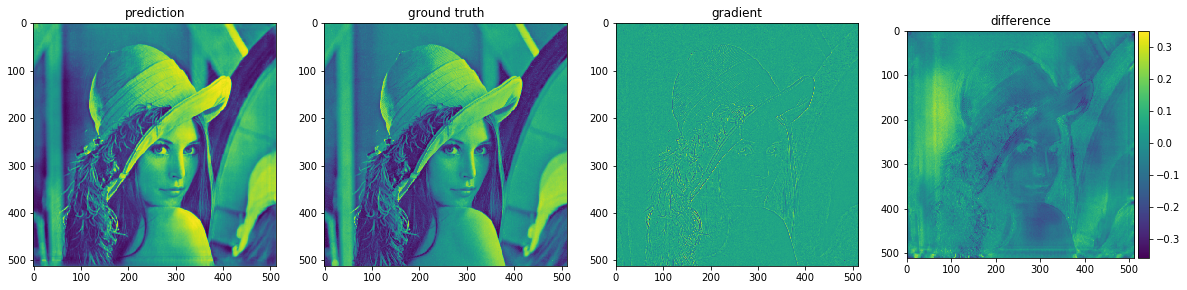

MAE is 0.06045099841336831


In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 4)
axs[0].set_title('prediction')
axs[0].imshow(prediction)
axs[1].set_title('ground truth')
axs[1].imshow(ground_truth)
axs[2].set_title('gradient')
axs[2].imshow(gradient)
ground_truth = (ground_truth-np.amin(ground_truth))/(np.amax(ground_truth)-np.amin(ground_truth)+1.0e-10)
prediction = (prediction-np.amin(prediction))/(np.amax(prediction)-np.amin(prediction)+1.0e-10)
diff = ground_truth - prediction
axs[3].set_title('difference')
im = axs[3].imshow(diff)
divider = make_axes_locatable(axs[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

print( f'MAE is {np.sum(np.abs(diff))/(512*512)}' )
